In [1]:
from pathlib import Path

import tqdm
import pandas as pd
import geopandas as gpd

import networkx as nx

import matplotlib.pyplot as plt

# 1. Load station name list

In [5]:
from utils.load_data import load_metro_station_list

city = 'suzhou'

data_folder = Path.cwd().parent / city

# Load metro station list
path = data_folder / f'metro_network_{city}.xlsx'
data = load_metro_station_list(path, time_status='current')
# drop duplicates
# data = data.drop_duplicates(subset=['line_name', 'name'])
# Select date
data = data[data['opening_date'] <= '2024-06-30']
# assign station id
data = data.assign(station_id = lambda x : range(x.shape[0]))

print('\nShape of station list data:', data.shape,
      '\nShape of data after removing duplicates:', data.drop_duplicates(subset=['line_name', 'name']).shape,
      '\nNumber of NA values:', data.isna().sum().sum())

Loading data: 8it [00:00, 21.03it/s]


Shape of station list data: (228, 14) 
Shape of data after removing duplicates: (228, 14) 
Number of NA values: 408


In [5]:
from codes.utils.create_graph import (
    graph_add_nodes_from_dataframe, 
    graph_add_edges_l_sapce_from_dataframe, 
    graph_add_edges_p_sapce_from_dataframe)


# data
line_station = data.query('line_name == "Pujiang"').reset_index(drop=True)

# attributes
node_id_col = 'station_id'
node_attr = ['name', 'name_zh', 'lon', 'lat',
             'line_name', 'line_color', 'line_cycle']
edge_attr = ['line_name', 'line_color', 'line_cycle']

# is cycle line
cycle = line_station['line_cycle'].unique().tolist()[0]


# L-Space
graph = nx.Graph()
graph = graph_add_nodes_from_dataframe(graph, line_station, node_id_col, node_attr)
graph = graph_add_edges_l_sapce_from_dataframe(graph, line_station, node_id_col, edge_attr, cycle=cycle)

# print node ids
print('\nL-Space representation:',
      '\nNumber of nodes:', graph.number_of_nodes(),
      '\nNumber of edges:', graph.number_of_edges(),
      '\nNode ids:', graph.nodes(),
      '\nEdge ids:', graph.edges())


# P-Space
graph = nx.Graph()
graph = graph_add_nodes_from_dataframe(graph, line_station, node_id_col, node_attr)
graph = graph_add_edges_p_sapce_from_dataframe(graph, line_station, node_id_col, edge_attr, cycle=cycle)

# print node ids
print('\nP-Space representation:',
      '\nNumber of nodes:', graph.number_of_nodes(),
      '\nNumber of edges:', graph.number_of_edges(),
      '\nNode ids:', graph.nodes(),
      '\nEdge ids:', graph.edges())

NameError: name 'data' is not defined

In [5]:
from codes.utils.create_graph import create_graph_from_dataframe

# attributes
node_id_col = 'station_id'
node_attr = ['name', 'name_zh', 'lon', 'lat',
             'line_name', 'line_color', 'line_cycle']
edge_attr = ['line_name', 'line_color', 'line_cycle']


graph = create_graph_from_dataframe(
    data, 
    node_id_col = 'station_id',
    order_col = 'no', 
    line_name_col = 'line_name', 
    flag_cycle_col = 'line_cycle', 
    node_attr_list = node_attr, 
    edge_attr_list = edge_attr, 
    space = 'l')

from codes.utils.graph_statistic import print_graph_basic_information
print_graph_basic_information(graph)

Creating graph: 100%|██████████| 22/22 [00:00<00:00, 77.32it/s]



Directed: False 
Number of nodes: 514 
Number of edges: 493


NameError: name 'node_data' is not defined

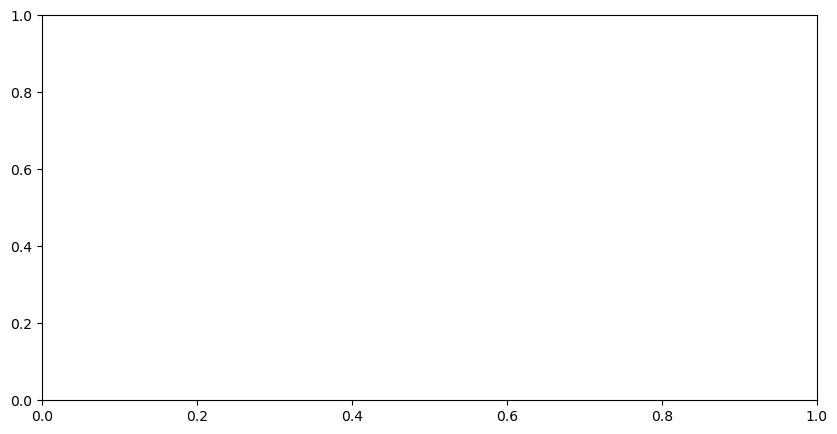

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot nodes
ax.scatter(
    node_data['lon'], node_data['lat'], 
    s=5, 
    c=node_data['line_color'], marker='o', label='station')


# plot edges
legend_handles = []
legend_labels = []

for (node_start, node_end, edge_attr) in graph.edges(data=True):
    
    x1, y1 = graph.nodes(data=True)[node_start]['lon'], graph.nodes(data=True)[node_start]['lat']
    x2, y2 = graph.nodes(data=True)[node_end]['lon'], graph.nodes(data=True)[node_end]['lat']
    color = edge_attr['line_color']
    label = edge_attr['line_name']

    handle = ax.plot([x1, x2], [y1, y2], c=color, 
                     lw=1.5, alpha=1, label=label)
    
    if label not in legend_labels:
        legend_handles.append(handle[0])
        legend_labels.append(label)

ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

In [6]:
transfer_station = data['name'].value_counts()
transfer_station = transfer_station[transfer_station > 1].index.tolist()

data.query('name in @transfer_station') \
    .sort_values(by=['line_name', 'no']) \
    .drop(columns=['no', 'cumulative_distance', 'station_spacing', 'line_color', 'line_cycle', 'location_gcj02'], axis=1) \
    .to_csv('transfer_station.csv', index=False)